# Create training dataset with Label-Maker for detecting building footprint

In this usecase, we will create a training dataset for detecting roads footprint of Dar es Salaam with Label Maker. We will then train a neural net for building segmentation. You can find the **final model prediction, vectorized roads for Dar es Salaam**, here: https://github.com/Geoyi/FOSS_4g_Pixel_decoder/blob/master/tz_road_prediction.geojson

Before the taining dataset creation, I recommend you go throught these steps. 

- [setup a python virtual environment](https://gist.github.com/wronk/a902185f5f8ed018263d828e1027009b); I use python 3.6.3.
- [install Tippecanoe](https://github.com/mapbox/tippecanoe) and [pip install label maker](https://github.com/developmentseed/label-maker);
- `pip install jupyter`;
- [Register and get Mapbox access token](https://www.mapbox.com/help/how-access-tokens-work/)
- run this python notebook and follow allowing the following instruction.

In [ ]:
%%file config.json 
{
  "country": "united_republic_of_tanzania",
  "bounding_box": [39.22222137451172,-6.8209322101709935,39.28736686706543,-6.776955027395981],
  "zoom": 17,
  "classes": [
    { "name": "Roads", "filter": ["has", "highway"] , "buffer": 2}
  ],
  "imagery": "https://a.tiles.mapbox.com/v4/mapbox.satellite/{z}/{x}/{y}.jpg?access_token=TOKEN"
  "ml_type": "segmentation"
}

In [ ]:
!label-maker download --dest tz_roads --config config.json

In [ ]:
!label-maker labels --dest tz_roads --config config.json

In [ ]:
!label-maker images --dest tz_roads --config config.json

### Move `tz_roads` direcotry to the following GPU EC2 instance.

# Move to a GPU cloud computer

This example was made from AWS P2.xlarge machine, it's an **Ubuntu Deep Learning AMI** for specific. 

I did these following steps to be able to start this notebook in the cloud computer with `Nvidia-Docker`.

- 1. install [docker](https://docs.aws.amazon.com/AmazonECS/latest/developerguide/docker-basics.html) and [nvidia-docker](https://towardsdatascience.com/using-docker-to-set-up-a-deep-learning-environment-on-aws-6af37a78c551) on AWS EC2 p2.xlarge instance;
- 2. running `git clone https://github.com/Geoyi/FOSS_4g_Pixel_decoder.git` and `cd FOSS_4g_Pixel_decoder`;
- 3. built the nvidia-docker image to run the notebook, by running `docker build -t pixel-decoder-notebook .`, it will create a nvidia-docker called `pixel-decoder-notebook`;
- 4. incide the `FOSS_4g_Pixel_decoder` directory, run `git clone https://github.com/Geoyi/pixel-decoder.git`, and move the notebook `Label-Maker_Pixel-Decoder.ipynb` to `pixel-decoder` directory;
- 5. `cd pixel-decoder` and run `nvidia-docker run -v $PWD:/example -p 8888:8888 -it pixel-decoder-notebook`;
- 6. in another terminal tag, log in and active to your notebook by runnin `ssh -i Your_AWS.pem -L 8888:localhost:8888 ubuntu@ec2-XX-XXX-XXX-XXX.compute-1.amazonaws.com`;
- log in to your notebook in your browser by runnin `localhost:8888/?token=xxxxxx`;

Now you are ready to run next steps.


In [ ]:
!pip install -e .

### label-maker mask dataset coverting

The labels/masks png from label maker is in 3-color channel, if you open one of them in numpy the shape is (256, 256, 3). The following script is the fastest way to covert labels to a gay color png. Find the `label.npz` that generated from your Label Maker. 

In [ ]:
from os import makedirs, path as op
from PIL import Image
import numpy as np
import os
import scipy.misc
labels = np.load('tz_roads/labels.npz') #The arrays in labels.npz are already 2D, just need to convert the numpy arrays to png 

for label in labels.files:
    new_label_dir = op.join(os.getcwd(), "new_labels")
    if not op.isdir(new_label_dir):
        makedirs(new_label_dir)
    img = labels[label]
    scipy.misc.imsave('{}/{}.png'.format(new_label_dir, label), img)
    print('Writing {}'.format(label))

In [ ]:
!pixel_decoder train --batch_size=16 \
                    --imgs_folder=tiles \
                    --masks_folder=new_labels \
                    --models_folder=tz_roads_model \
                    --model_id=resnet_unet \
                    --origin_shape_no=256 \
                    --border_no=32

Pixel_decoder predict function takes tif files as inputs (if path.isfile(path.join(test_folder, f)) and '.tif' in f:), this little script converts the png into tif

In [ ]:
new_label_dir = op.join(os.getcwd(), "tz_roads/test_tiles/")
if not op.isdir(new_label_dir):
    makedirs(new_label_dir)

from os import path, listdir, mkdir
for f in listdir(path.join("tz_roads/tiles/")):
    img = "tz_roads/tiles/" + f
    im = Image.open(img)
    im.save(('tz_roads/test_tiles/' + f).replace(".jpg",".tif"))

In [ ]:
!pixel_decoder predict --imgs_folder=tiles\
                    --test_folder=test_tiles \
                    --models_folder=tz_roads_model \
                    --pred_folder=predictions_tz_roads \
                    --model_id=resnet_unet \
                    --origin_shape_no=256 \
                    --border_no=32

In [ ]:
import os, glob
import numpy as np
from os import path as op
import matplotlib.pyplot as plt
%matplotlib inline
import skimage.io

In [ ]:
tiles =sorted(glob.glob("tiles_road/*.jpg"))

def grey2rgb(img):
    """
    Create model prediction result to 3 channel, so we can see the result in black and white.
    """
    new_img = []
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            new_img.append([img[i][j]]*3)
    new_img = np.array(new_img).reshape(img.shape[0], img.shape[1], 3)
    return new_img

In [ ]:
pred_list = [op.basename(f).split(".")[0] for f in preds]

In [ ]:
new_label_dir = op.join(os.getcwd(), "result_figures")
if not op.isdir(new_label_dir):
    makedirs(new_label_dir)

for pred in pred_list:
    img = skimage.io.imread("tz_roads/tiles/{}.jpg".format(pred))
    mask = skimage.io.imread("tz_roads/labels/{}.png".format(pred))
    pred_mask = grey2rgb(skimage.io.imread("predictions_tz_roads/resnet_unet/{}.png".format(pred)))
    masked = np.ma.masked_where(pred_mask >=1, pred_mask) 

    fig, ax =  plt.subplots(1, 3, figsize=(30, 10))
    ax[-3].imshow(img, 'gray', interpolation='none')
    ax[-3].set_title('Origin RGB image Tile')

    ax[-2].imshow(img, 'gray', interpolation='none')
    ax[-2].imshow(mask, 'jet', interpolation='none', alpha=0.6)
    ax[-2].set_title('Ground-truth over image')

    ax[-1].imshow(img, 'gray', interpolation='none')
    ax[-1].imshow(masked, 'jet', interpolation='none', alpha=0.6)
    ax[-1].set_title('Predition over images')

    fig.savefig("result_figures/tz_roads_pred_{}.png".format(pred))

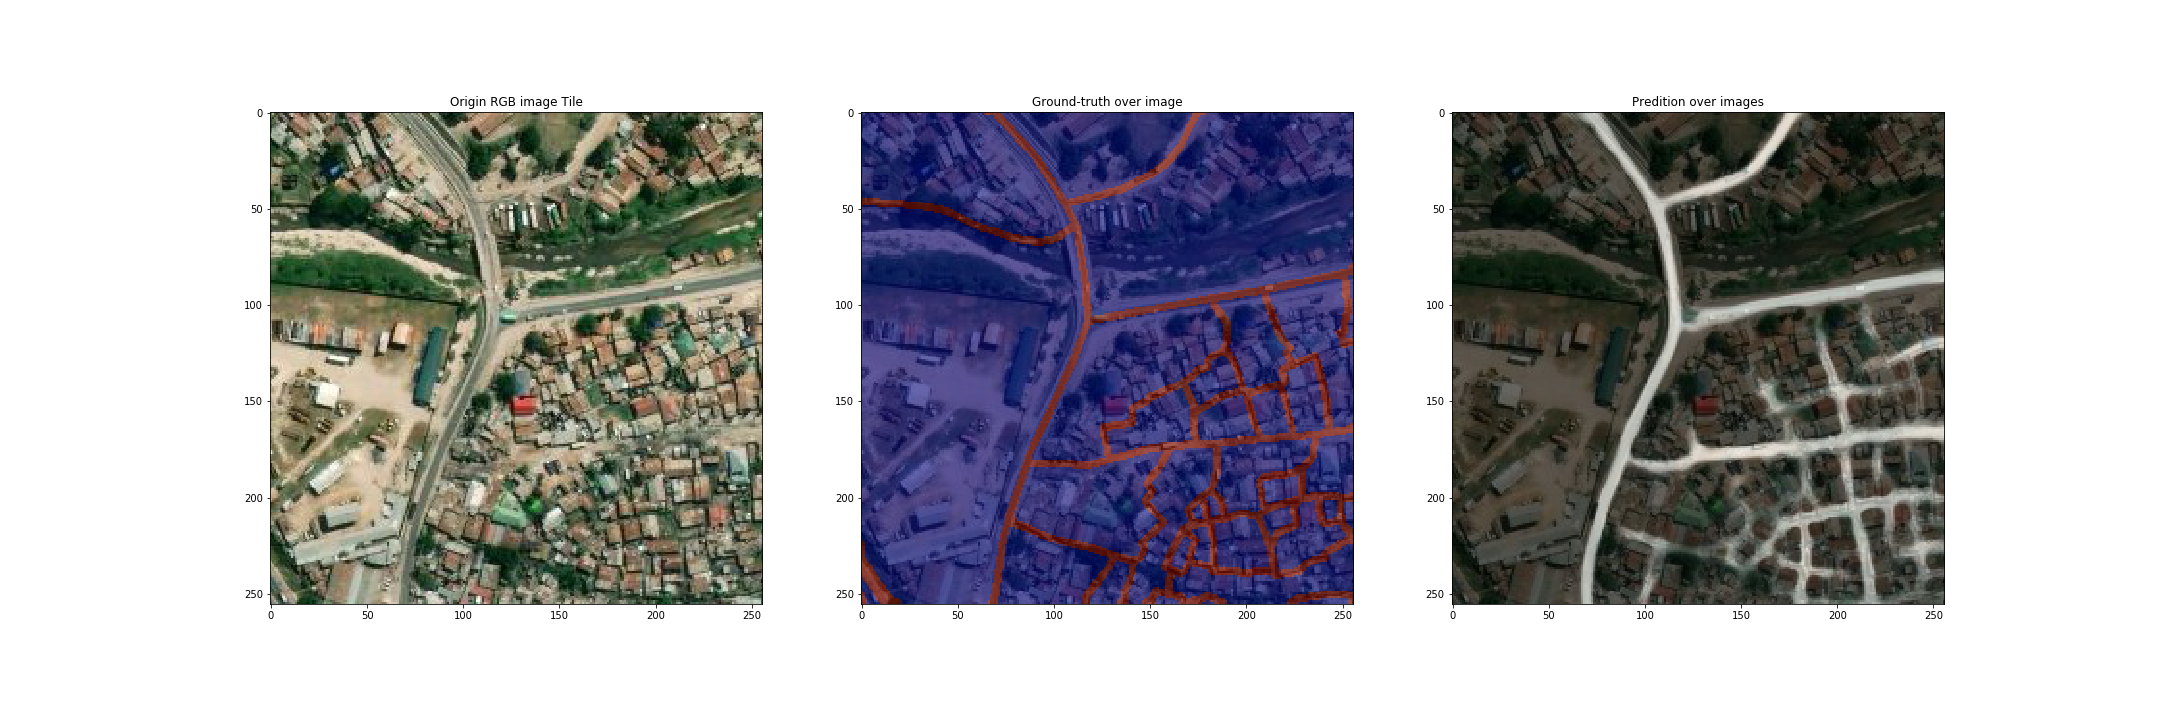

In [1]:
from IPython.display import Image
Image(filename='roads_predictions_figs/tz_buildings_pred_79829-68024-17.png')

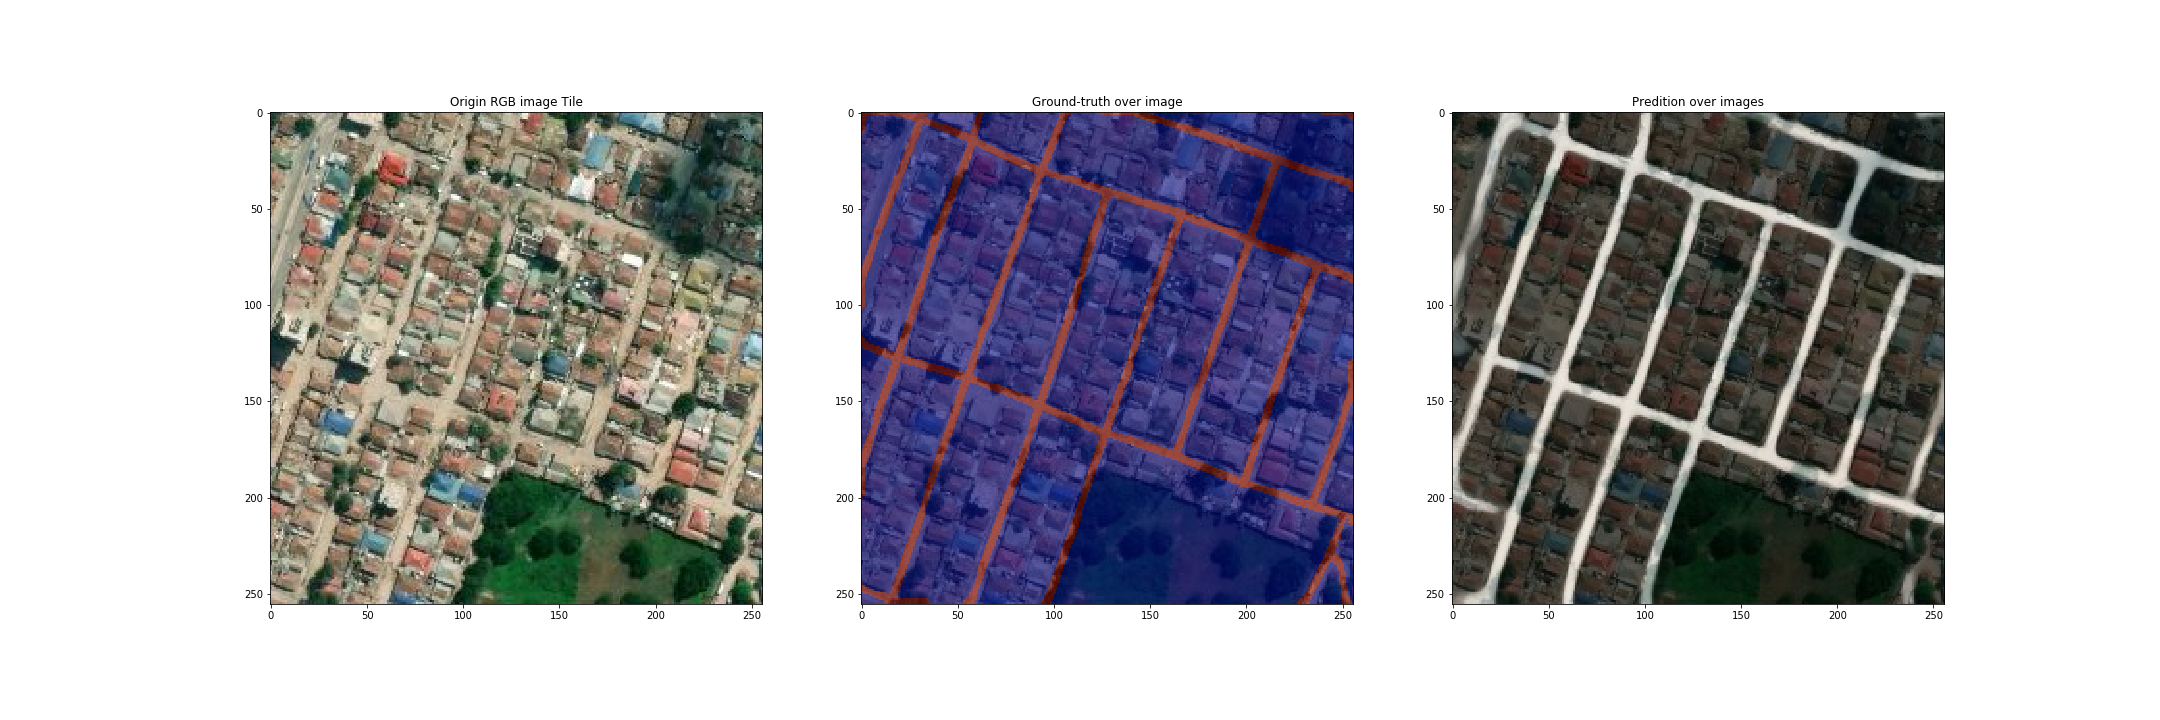

In [2]:
Image(filename='roads_predictions_figs/tz_buildings_pred_79830-68021-17.png')

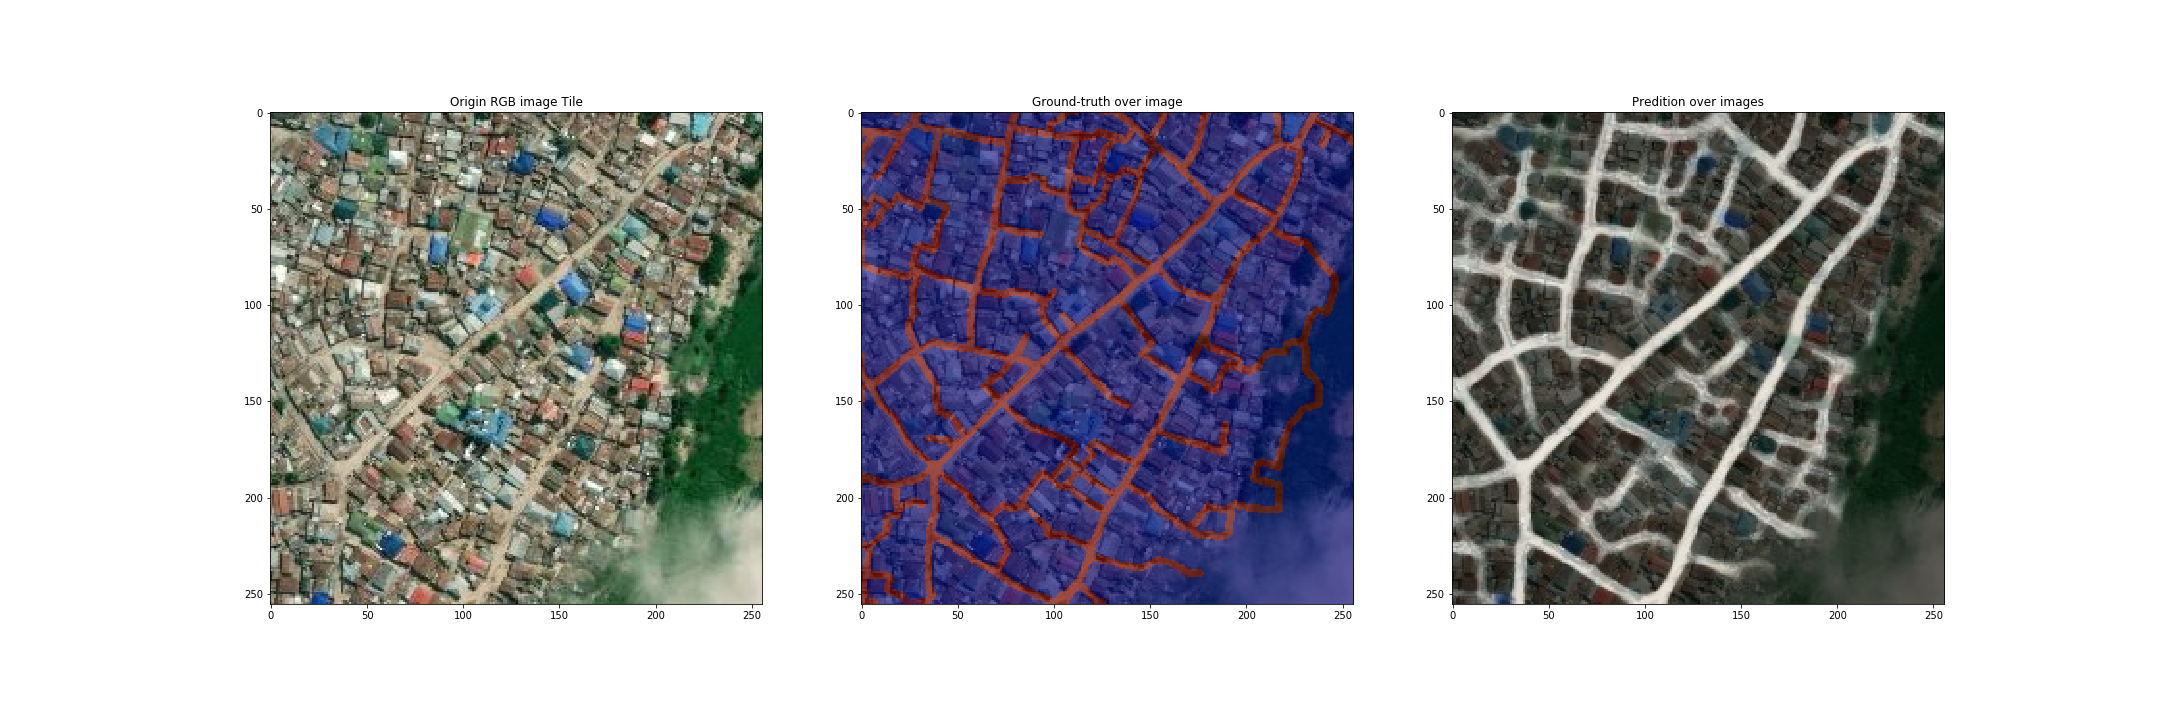

In [3]:
Image(filename='roads_predictions_figs/tz_buildings_pred_79832-68018-17.png')

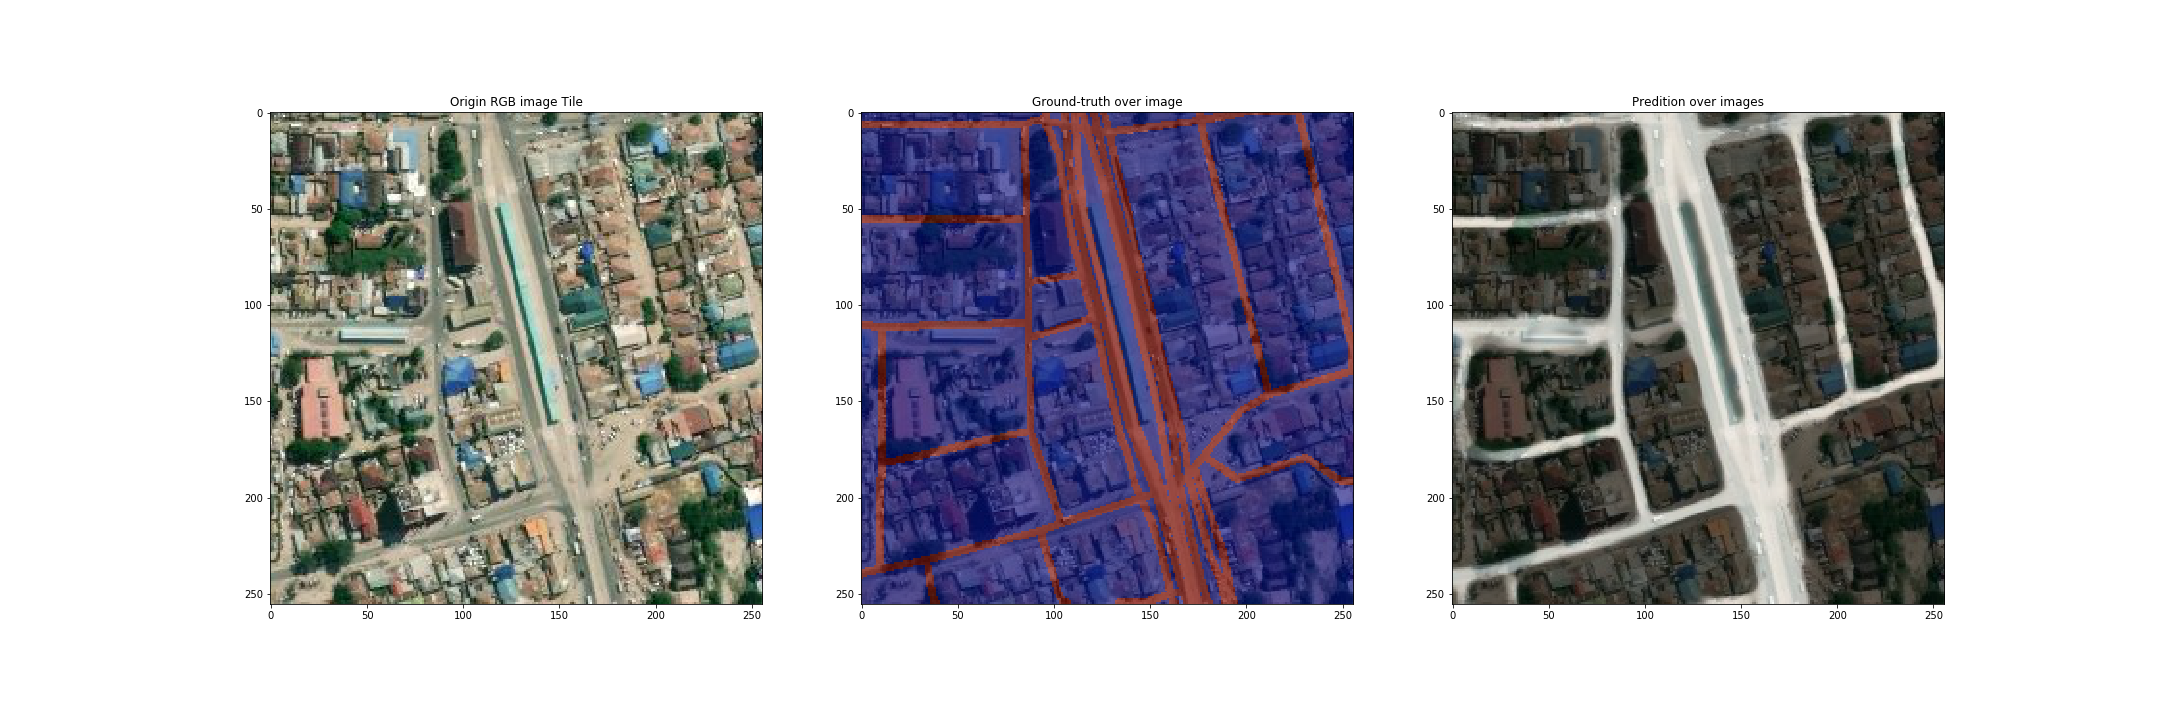

In [6]:
Image(filename='roads_predictions_figs/tz_buildings_pred_79831-68014-17.png')